In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's Pipeline
import time

<b><mark>Preparing modeling data, based on data understaning and data preparation done for the baseline model developed earlier.</mark></b>

In [2]:
transaction_df2 = pd.read_csv('data/AIML Dataset.csv')

df_modeling2 = transaction_df2.drop(['step','nameOrig','nameDest','isFlaggedFraud'], axis=1)

# Creating the datasets for modeling
y2 = df_modeling2['isFraud']
X2 = df_modeling2.drop('isFraud', axis=1)

# Splitting the date into Training Set and Testing Set
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify = y2, test_size=.3)

numeric = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
categorical = ['type']

### <mark>Comparision Model - Random Forest</mark>

<b><mark>Random Forect Classifier with <b>Synthetic Minority Over-sampling Technique (SMOTE)</mark></b>

In [3]:
# Create preprocessor with passthrough
preprocessor2 = ColumnTransformer(transformers = [("numeric", StandardScaler(), numeric), ("catigorical", OneHotEncoder(), categorical)], remainder='passthrough')

# Create SMOTE
smote2 = SMOTE(random_state=42)

# Create imblearn pipeline with preprocessor, SMOTE, and Random Forest Classifier
pipeline2 = ImbPipeline([("prepocessor", preprocessor2), ('smote', smote2), ("model", RandomForestClassifier(class_weight = "balanced", n_jobs=-1, random_state=42))])
pipeline2

,steps,"[('prepocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('numeric', ...), ('catigorical', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready f

In [5]:
# Fit the imblearn pipeline (ensure SMOTE is only applied to the training data)
start_time = time.perf_counter()
pipeline2.fit(X_train2, y_train2)
end_time = time.perf_counter()

# Calculate and print the training time
training_duration = end_time - start_time
print(f"Random Forest Classifier (using SMOTE) training took: {training_duration:.4f} seconds")

# Predict using test data
y_test_predict2 = pipeline2.predict(X_test2)

# Generate and display Classification Report.
print("Random Forest Classification Report using SMOTE:")
print(classification_report(y_test2, y_test_predict2))

# Generate and display Confusion Matrix.
print("Random Forest Confusion Matrix using SMOTE:")
print(confusion_matrix(y_test2, y_test_predict2))

Random Forest Classifier (using SMOTE) training took: 197.5757 seconds
Random Forest Classification Report using SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.59      0.96      0.73      2464

    accuracy                           1.00   1908786
   macro avg       0.80      0.98      0.87   1908786
weighted avg       1.00      1.00      1.00   1908786

Random Forest Confusion Matrix using SMOTE:
[[1904684    1638]
 [     98    2366]]


<b><mark>Evaluating by Cross-Validation using Stratified K-Fold cross-validation</mark></b>

Random Forest Classifier (using SMOTE) cross-validation took: 1236.1868 seconds
Random Forest Overall Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   6354407
           1       0.61      0.96      0.75      8213

    accuracy                           1.00   6362620
   macro avg       0.81      0.98      0.87   6362620
weighted avg       1.00      1.00      1.00   6362620

Overall Confusion Matrix:
[[6349425    4982]
 [    358    7855]]


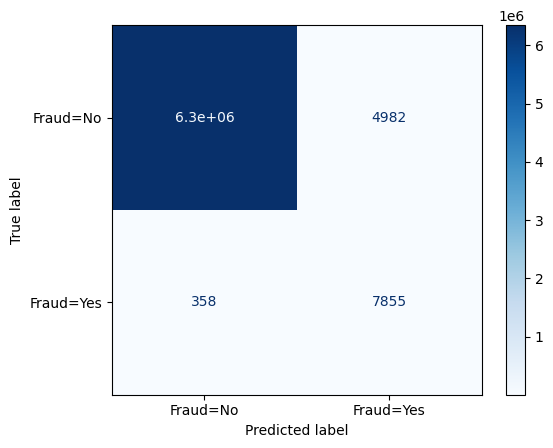

In [7]:
# Create preprocessor with passthrough
preprocessor2 = ColumnTransformer(transformers = [("numeric", StandardScaler(), numeric), ("catigorical", OneHotEncoder(), categorical)], remainder='passthrough')

# Create SMOTE
smote2 = SMOTE(random_state=42)

# Create imblearn pipeline with preprocessor, SMOTE, and Random Forest Classifier
pipeline2 = ImbPipeline([("prepocessor", preprocessor2), ('smote', smote2), ("model", RandomForestClassifier(class_weight = "balanced", n_jobs=-1, random_state=42))])

# Configure Stratified k-Fold with 5 folds, shuffle = True for better results, and set a random state for reproducibility
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get the cross-validated predictions for each test fold
start_time = time.perf_counter()
y_all_predict2 = cross_val_predict(pipeline2, X2, y2, cv=skf, n_jobs=-1) # n_jobs=-1 means using all available CPUs
end_time = time.perf_counter()

# Calculate and print the cross-validation time
training_duration = end_time - start_time
print(f"Random Forest Classifier (using SMOTE) cross-validation took: {training_duration:.4f} seconds")

# Generate overall Classification Report
print("Random Forest Overall Classification Report:")
print(classification_report(y2, y_all_predict2))

# Generate overall Confusion Matrix
conf_mat = confusion_matrix(y2, y_all_predict2)
# Plot overall Confusion Matrix using ConfusionMatrixDisplay
print("Overall Confusion Matrix:")
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['Fraud=No', 'Fraud=Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Observations

<mark><b>Random Forest Classifier has significant improvements over the baseline Logistic Regression model.</b></mark>

1. The <mark><b>false positives (the main drawback in our baseline Logistic Regression model) are drastically reduced with Random Forest Classifier</b></mark>. As a result, <mark><b>Precision Score for Fraud class of Random Forest Classifier is 61%</b></mark>, as compared to 2% Precision Score of the Logistic Regression. <mark>Out of the 12,837 transactions classified as fraud by the model in the entire data, 7,855 were actually fraud</mark>.
   
2. The <mark><b>Recall Score for Fraud class of Random Forest Classifier is 96%</b></mark>, that is almost same as compared to 95% Recall Score of the Logistic Regression. <mark>The model correctly classified 7,855 out of 8,213 fraud transactions in the entire data</mark>.

3. Primarily due to the improvement in Precision Score, the <mark><b>F1-Score for Fraud class of Random Forest Classifier is 75%</b></mark>, as compared to 4% F1-Score of the Logistic Regression.

4. The overall <mark><b>Accuracy of Random Forest Classifier is 100%</b></mark>,as compared to 95% Accuracy of the Logistic Regression. <mark>The model correctly classified 6,357,280 out of 6,362,620 total transactions in the entire data</mark>.
